In [296]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from matplotlib import transforms
import seaborn as sns
import math
from pprint import pprint
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
#Import the dataset and define the feature as well as the target datasets / columns#
dataset = pd.read_csv('zoo.csv')#Import all columns omitting the fist which consists the names of the animals
#We drop the animal names since this is not a good feature to split the data on
dataset=dataset.drop('animal_name',axis=1)

In [3]:
def entropy(target_col):
    """
    Calculate the entropy of a dataset.
    The only parameter of this function is the target_col parameter which specifies the target column
    """
    elements,counts = np.unique(target_col,return_counts = True)
#     print(elements)
#     print(counts)
    entropy = 0
    for i in range(len(elements)):
        entropy += (-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts))
    return entropy

In [4]:
def information_gain(df, attribute_name, target_name="class_type"):
    """Counts information gain for chosen attribute"""
    total_entropy = entropy(df[target_name])
    unique_values, counts = np.unique(df[attribute_name],return_counts = True)
    res = 0
    for un_v, cn in zip(unique_values, counts):
        #print(cn, un_v)
        res += entropy(df.loc[df[attribute_name]==un_v][target_name])*(cn/np.sum(counts))
    return total_entropy - res

In [5]:
entropy(dataset["class_type"])

2.390559682294039

In [6]:
info_gain = [information_gain(dataset, att) for att in dataset.columns  ]

In [7]:
info_gain

[0.7906745736101795,
 0.717949976500291,
 0.8301384483633478,
 0.9743197211096903,
 0.4697026095047725,
 0.3894874837982223,
 0.09344704054083186,
 0.8656941534932372,
 0.6761627418829197,
 0.6144940279390552,
 0.13308962953512316,
 0.4666135671503897,
 1.3630469031539394,
 0.5004604482515027,
 0.05066877984551832,
 0.3084903449142815,
 2.390559682294039]

In [84]:
def ID3(data, original_data, features, target_attribute_name="class_type", parent_node_class=None):
    
            #If all target attributes have the same value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
        #If the dataset is empty
    elif len(data) == 0:
        num_of_appears = np.unique(original_data[target_attribute_name],return_counts=True)[1]#How many of each class instance
        index = np.argmax(num_of_appears)
        return np.unique(original_data[target_attribute_name])[index]
        #If there are no more attributes
    elif len(features) == 0:
        return parent_node_class
            # If none of stop criterias are satisfied we can grow tree!!
    else:
        num_of_appears = np.unique(original_data[target_attribute_name],return_counts=True)[1]#How many of each class instance
        index = np.argmax(num_of_appears)
        parent_node_class = np.unique(original_data[target_attribute_name])[index]#It will be equal to mode of original class
        
            #Then select attribute(feature) with the best information gain
        info_gain_attributes = [information_gain(data, att, target_attribute_name) for att in features]
        #Thus we will return infGain value for each attribute
        best_feature_index = np.argmax(info_gain_attributes)
        best_feature = features[best_feature_index]#Here we got best attribute to split
        
        #Create the tree structure. The root gets the name of the feature (best_feature) with the maximum information
        #gain in the first run
        tree = {best_feature:{}}
        
        #Remove the feature with the best inforamtion gain from the feature space
        features = [i for i in features if i != best_feature]
        
        #Grow a branch under the root node for each possible value of the root node feature
        for value in np.unique(data[best_feature]):
            value = value
            #Split the dataset according to the value of the feature with the largest information gain and therwith create sub_datasets
            sub_data = data.where(data[best_feature] == value).dropna()
            
            #Call the ID3 algorithm for each of those sub_datasets with the new parameters --> Here the recursion comes in!
            subtree = ID3(sub_data,original_data,features,target_attribute_name,parent_node_class)
            
            #Add the sub tree, grown from the sub_dataset to the tree under the root node
            tree[best_feature][value] = subtree
        
    return tree

In [196]:
def predict(query,tree,default = 1):
    #1.
    for key in list(query.keys()):
        if key in list(tree.keys()):
            #2.
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            #3.
            result = tree[key][query[key]]
            #4.
            if isinstance(result,dict):
                return predict(query,result)

            else:
                return result

In [295]:
def my_train_test_split(datas):
    datas = datas.sample(frac=1)
    training_data = datas.iloc[:100].reset_index(drop=True)#We drop the index respectively relabel the index
    #starting form 0, because we do not want to run into errors regarding the row labels / indexes
    testing_data = datas.iloc[50:].reset_index(drop=True)
    return training_data,testing_data

training_data = my_train_test_split(frame_test5)[0]
testing_data = my_train_test_split(frame_test5)[1] 



def test(data,tree,target_attribute):
    #Create new query instances by simply removing the target feature column from the original dataset and 
    #convert it to a dictionary
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    
    #Create a empty DataFrame in whose columns the prediction of the tree are stored
    predicted = pd.DataFrame(columns=["predicted"]) 
    
    #Calculate the prediction accuracy
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0) 
    print('The prediction accuracy is: ',(np.sum(predicted["predicted"] == data[target_attribute])/len(data))*100,'%')
    

# My ID3 for zoo


In [268]:
train_zoo, test_zoo = train_test_split(dataset, test_size=0.3)
train_zoo = train_zoo.reset_index(drop=True)
test_zoo = test_zoo.reset_index(drop=True)

{'legs': {0: {'fins': {0.0: {'toothed': {0.0: 7.0, 1.0: 3.0}},
                       1.0: {'eggs': {0.0: 1.0, 1.0: 4.0}}}},
          2: {'hair': {0.0: 2.0, 1.0: 1.0}},
          4: {'hair': {0.0: {'predator': {0.0: 5.0, 1.0: 7.0}}, 1.0: 1.0}},
          5: 7.0,
          6: {'aquatic': {0.0: 6.0, 1.0: 7.0}},
          8: 7.0}}
The prediction accuracy is:  83.87096774193549 %


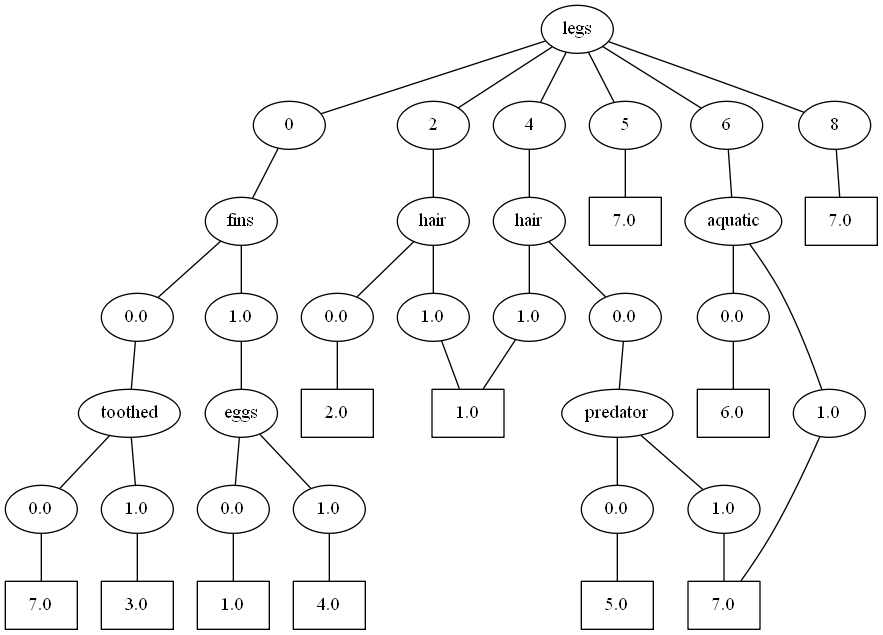

In [271]:
tree_zoo = ID3(train_zoo,train_zoo,train_zoo.columns[:-1])
pprint(tree_zoo)
test(test_zoo,tree_zoo, "class_type")
plot_tree(tree_zoo,'tree_zoo')
from IPython.display import Image
Image(filename='tree_zoo.png') 

# Visualization from dictionary to tree

In [266]:
import pydot
def walk_dictionaryv2(graph, dictionary, parent_node=None):
    '''
    Recursive plotting function for the decision tree stored as a dictionary
    '''

    for k in dictionary.keys():

        if parent_node is not None:

            from_name = parent_node.get_name().replace("\"", "") + '_' + str(k)
            from_label = str(k)

            node_from = pydot.Node(from_name, label=from_label)
            graph.add_node(node_from)

            graph.add_edge( pydot.Edge(parent_node, node_from) )

            if isinstance(dictionary[k], dict): # if interim node


                walk_dictionaryv2(graph, dictionary[k], node_from)

            else: # if leaf node
                to_name = str(k) + '_' + str(dictionary[k]) # unique name
                to_label = str(dictionary[k])

                node_to = pydot.Node(to_name, label=to_label, shape='box')
                graph.add_node(node_to)
                graph.add_edge(pydot.Edge(node_from, node_to))

                #node_from.set_name(to_name)

        else:

            from_name =  str(k)
            from_label = str(k)

            node_from = pydot.Node(from_name, label=from_label)
            graph.add_node(node_from)
            walk_dictionaryv2(graph, dictionary[k], node_from)


def plot_tree(tree, name):

    # first you create a new graph, you do that with pydot.Dot()
    graph = pydot.Dot(graph_type='graph')

    walk_dictionaryv2(graph, tree)

    graph.write_png(name+'.png')


plot_tree(tree_zoo,'test_zoo')

# Tree obtained with full dataset

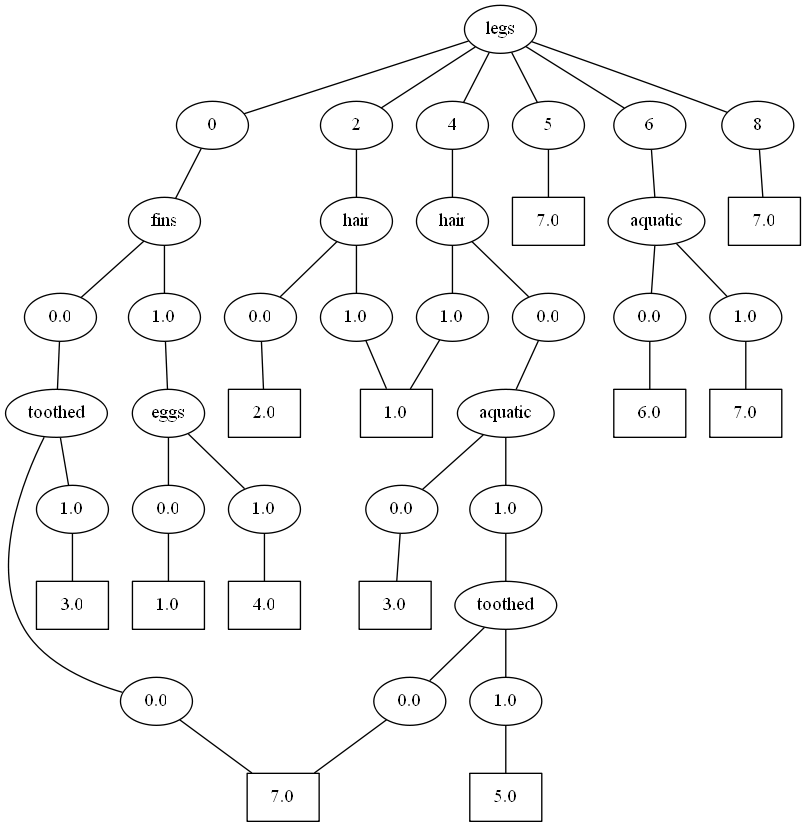

In [267]:
from IPython.display import Image
Image(filename='test_zoo.png') 

# Using sklearn DecisionTreeClassifier for Zoo

In [281]:
import sklearn.datasets as datasets
import pandas as pd
# iris=datasets.load_iris()
# df=pd.DataFrame(iris.data, columns=iris.feature_names)
# y=iris.target
zoo_set = train_zoo
target = train_zoo["class_type"]

In [284]:
from sklearn.tree import DecisionTreeClassifier
dtree_zoo=DecisionTreeClassifier()
dtree_zoo.fit(zoo_set,target)
prediction = dtree_zoo.predict(test_zoo)
print("The prediction accuracy is: ",dtree_zoo.score(test_zoo,test_zoo["class_type"])*100,"%")

The prediction accuracy is:  87.09677419354838 %


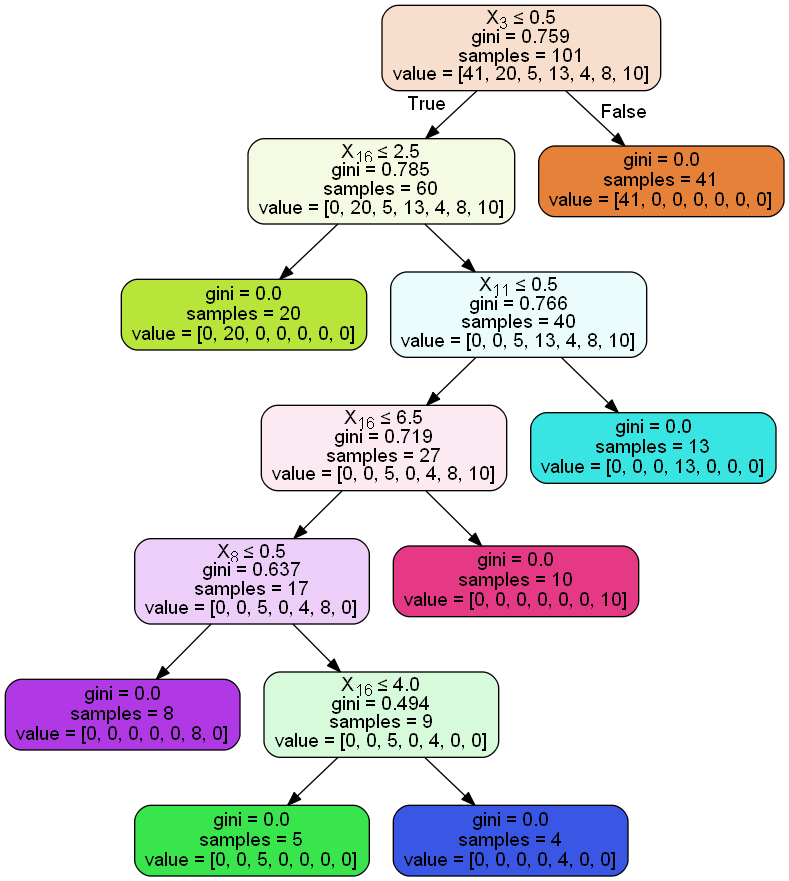

In [277]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree_zoo, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [73]:
value, counts = np.unique(dataset.where(dataset["feathers"]==0).dropna().class_type,return_counts=True )

In [74]:
print(value, counts)

[1. 3. 4. 5. 6. 7.] [41  5 13  4  8 10]


# Iris dataset

In [102]:
frame = pd.read_csv("iris.data")
frame.columns = ["Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width", "Species"]
target_att = "Species"
frame.head()
attr_values = frame.columns.drop(target_att)
attr_values
# del frame[target_att]

Index(['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width'], dtype='object')

In [86]:
tree1 = ID3(frame,frame,frame.columns[:-1],"Species")

In [193]:
pprint(tree1)

{'Petal.Length': {1.0: 'Iris-setosa',
                  1.1: 'Iris-setosa',
                  1.2: 'Iris-setosa',
                  1.3: 'Iris-setosa',
                  1.4: 'Iris-setosa',
                  1.5: 'Iris-setosa',
                  1.6: 'Iris-setosa',
                  1.7: 'Iris-setosa',
                  1.9: 'Iris-setosa',
                  3.0: 'Iris-versicolor',
                  3.3: 'Iris-versicolor',
                  3.5: 'Iris-versicolor',
                  3.6: 'Iris-versicolor',
                  3.7: 'Iris-versicolor',
                  3.8: 'Iris-versicolor',
                  3.9: 'Iris-versicolor',
                  4.0: 'Iris-versicolor',
                  4.1: 'Iris-versicolor',
                  4.2: 'Iris-versicolor',
                  4.3: 'Iris-versicolor',
                  4.4: 'Iris-versicolor',
                  4.5: {'Sepal.Length': {4.9: 'Iris-virginica',
                                         5.4: 'Iris-versicolor',
                         

# Here is what happens when you don't discretize your data

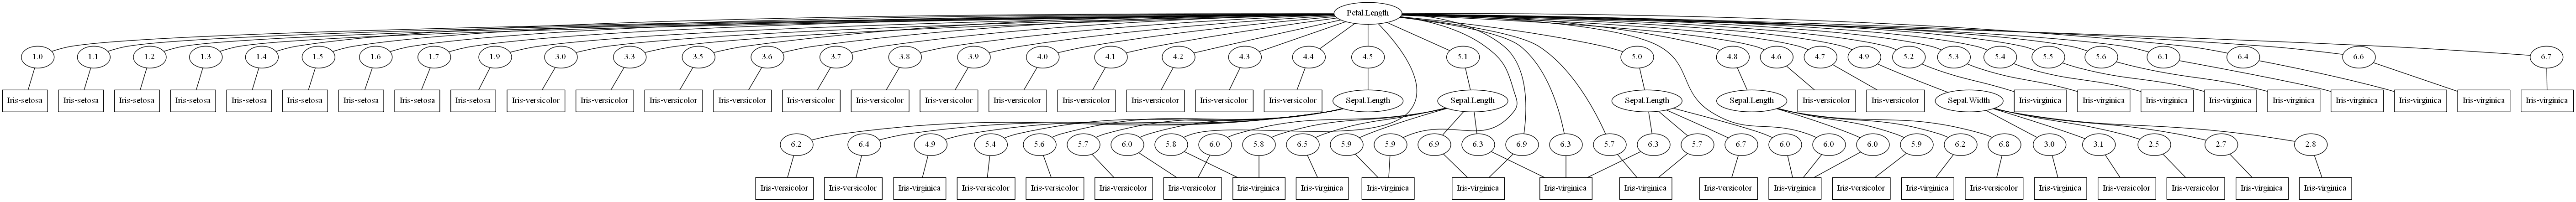

In [88]:
plot_tree(tree1,'test')
from IPython.display import Image
Image(filename='test.png') 

In [103]:
def descretization(df_in,num_buckets):
    """Discretize data set on such intervals, as num_buckets"""
    df = df_in.copy()
    for att in df.columns[:-1]:
        df[att] = pd.cut(df[att], num_buckets)
        
    return df

In [104]:
frame1 = frame.copy()

# Simple discretization(separating into 3 equal parts)

In [111]:
frame_test = descretization(frame1,3)

In [194]:
tree2 = ID3(frame_test,frame_test,frame_test.columns[:-1],"Species")
pprint(tree2)

{'Petal.Width': {Interval(0.0976, 0.9, closed='right'): 'Iris-setosa',
                 Interval(0.9, 1.7, closed='right'): {'Petal.Length': {Interval(2.967, 4.933, closed='right'): {'Sepal.Length': {Interval(4.296, 5.5, closed='right'): {'Sepal.Width': {Interval(1.998, 2.8, closed='right'): 'Iris-versicolor',
                                                                                                                                                                                        Interval(2.8, 3.6, closed='right'): 'Iris-versicolor'}},
                                                                                                                                 Interval(5.5, 6.7, closed='right'): 'Iris-versicolor',
                                                                                                                                 Interval(6.7, 7.9, closed='right'): 'Iris-versicolor'}},
                                                                       Interv

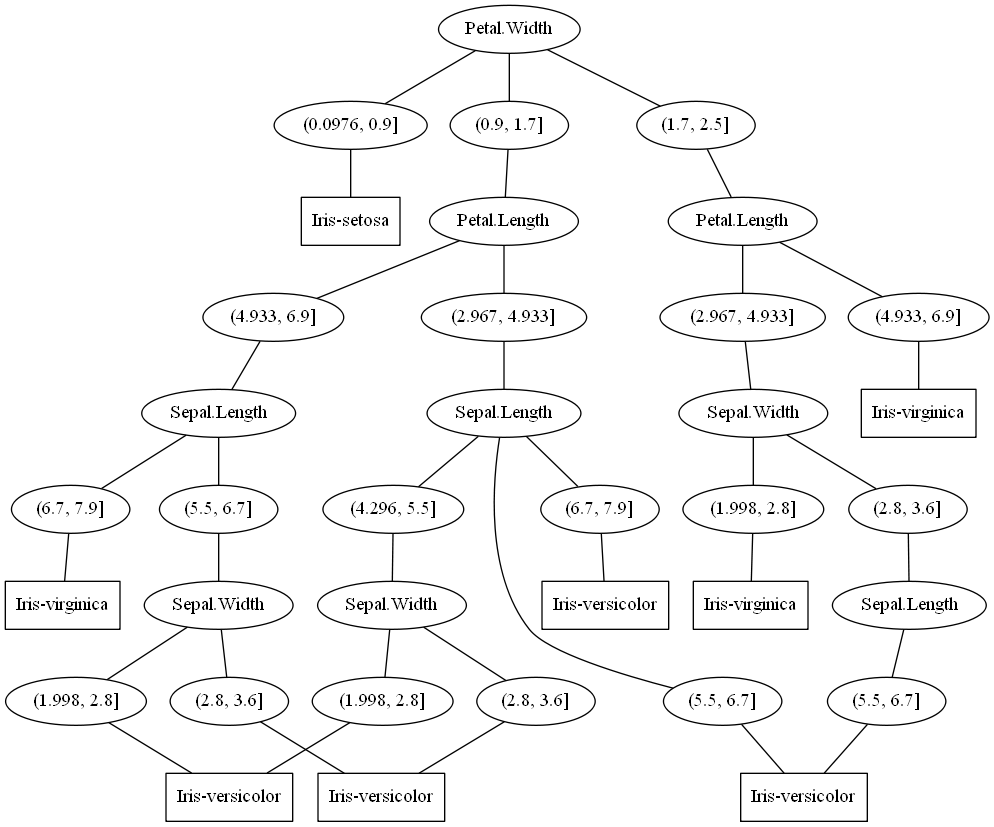

In [114]:
plot_tree(tree2,'test2')
from IPython.display import Image
Image(filename='test2.png') 

In [195]:
pprint(tree2)

{'Petal.Width': {Interval(0.0976, 0.9, closed='right'): 'Iris-setosa',
                 Interval(0.9, 1.7, closed='right'): {'Petal.Length': {Interval(2.967, 4.933, closed='right'): {'Sepal.Length': {Interval(4.296, 5.5, closed='right'): {'Sepal.Width': {Interval(1.998, 2.8, closed='right'): 'Iris-versicolor',
                                                                                                                                                                                        Interval(2.8, 3.6, closed='right'): 'Iris-versicolor'}},
                                                                                                                                 Interval(5.5, 6.7, closed='right'): 'Iris-versicolor',
                                                                                                                                 Interval(6.7, 7.9, closed='right'): 'Iris-versicolor'}},
                                                                       Interv

# Simple discretization(separating into 3 equal parts)

In [124]:
frame_test2 = descretization(frame1,2)

In [125]:
tree3 = ID3(frame_test2,frame_test2,frame_test2.columns[:-1],"Species")

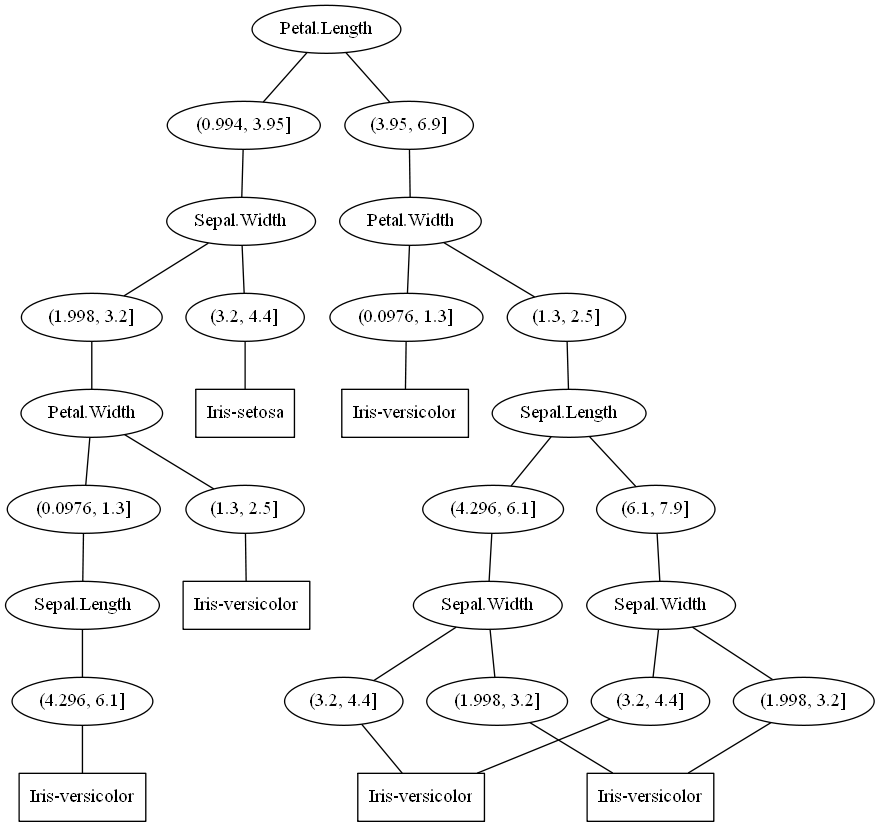

In [126]:
plot_tree(tree3,'test3')
from IPython.display import Image
Image(filename='test3.png') 

In [186]:
frame_test5 = descretization(frame1,3)

In [191]:

"""
Train the tree, Print the tree and predict the accuracy
"""
tree4 = ID3(training_data,training_data,training_data.columns[:-1], "Species")
pprint(tree4)
test(testing_data,tree4)

{'Petal.Width': {Interval(0.0976, 0.9, closed='right'): 'Iris-setosa',
                 Interval(0.9, 1.7, closed='right'): {'Petal.Length': {Interval(2.967, 4.933, closed='right'): {'Sepal.Length': {Interval(4.296, 5.5, closed='right'): {'Sepal.Width': {Interval(1.998, 2.8, closed='right'): 'Iris-versicolor',
                                                                                                                                                                                        Interval(2.8, 3.6, closed='right'): 'Iris-versicolor'}},
                                                                                                                                 Interval(5.5, 6.7, closed='right'): 'Iris-versicolor',
                                                                                                                                 Interval(6.7, 7.9, closed='right'): 'Iris-versicolor'}},
                                                                       Interv

# Simple discretization(separating into 6 equal parts)

In [260]:
frame_test_1 = descretization(frame1,6)#6 and 3 give us max accuracy

In [299]:
train1, test1 = train_test_split(frame_test_1, test_size=0.3)
train1 = train1.reset_index(drop=True)
test1 = test1.reset_index(drop=True)

{'Petal.Width': {Interval(0.0976, 0.5, closed='right'): 'Iris-setosa',
                 Interval(0.5, 0.9, closed='right'): 'Iris-setosa',
                 Interval(0.9, 1.3, closed='right'): 'Iris-versicolor',
                 Interval(1.3, 1.7, closed='right'): {'Sepal.Length': {Interval(4.296, 4.9, closed='right'): 'Iris-virginica',
                                                                       Interval(4.9, 5.5, closed='right'): 'Iris-versicolor',
                                                                       Interval(5.5, 6.1, closed='right'): 'Iris-versicolor',
                                                                       Interval(6.1, 6.7, closed='right'): {'Petal.Length': {Interval(3.95, 4.933, closed='right'): 'Iris-versicolor',
                                                                                                                             Interval(4.933, 5.917, closed='right'): 'Iris-virginica'}},
                                          

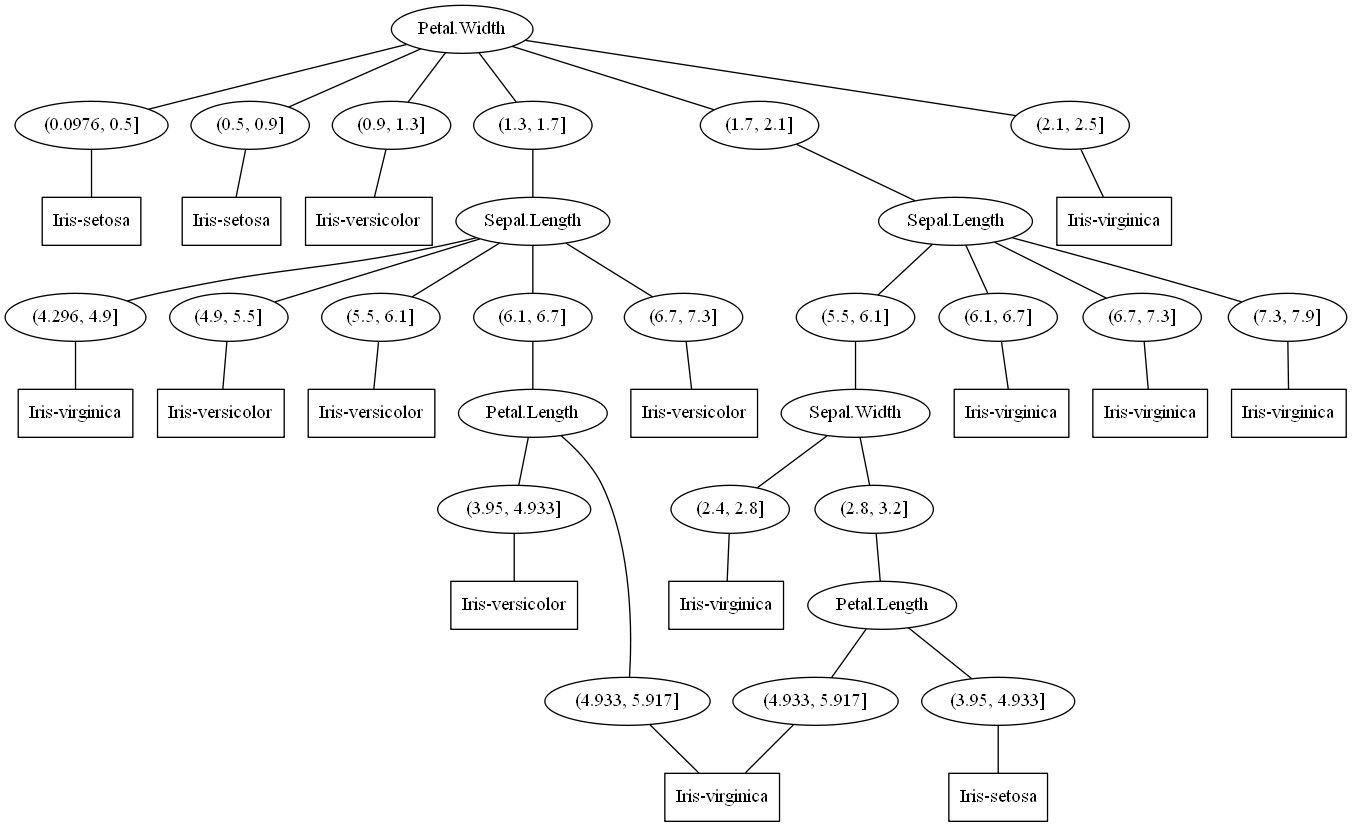

In [263]:
tree_1 = ID3(train1,train1,train1.columns[:-1], "Species")
pprint(tree_1)
test(test1,tree_1)
plot_tree(tree_1,'test_1')
from IPython.display import Image
Image(filename='test_1.png') 

# Using sklearn DecisionTreeClassifier for iris

In [302]:
df_iris=frame.copy()


In [303]:
train_iris, test_iris = train_test_split(df_iris, test_size=0.3)
train_iris = train_iris.reset_index(drop=True)
test_iris = test_iris.reset_index(drop=True)

In [313]:
iris_tree=DecisionTreeClassifier(criterion="entropy")
iris_tree.fit(train_iris.loc[:, train_iris.columns != 'Species'],train_iris.Species)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

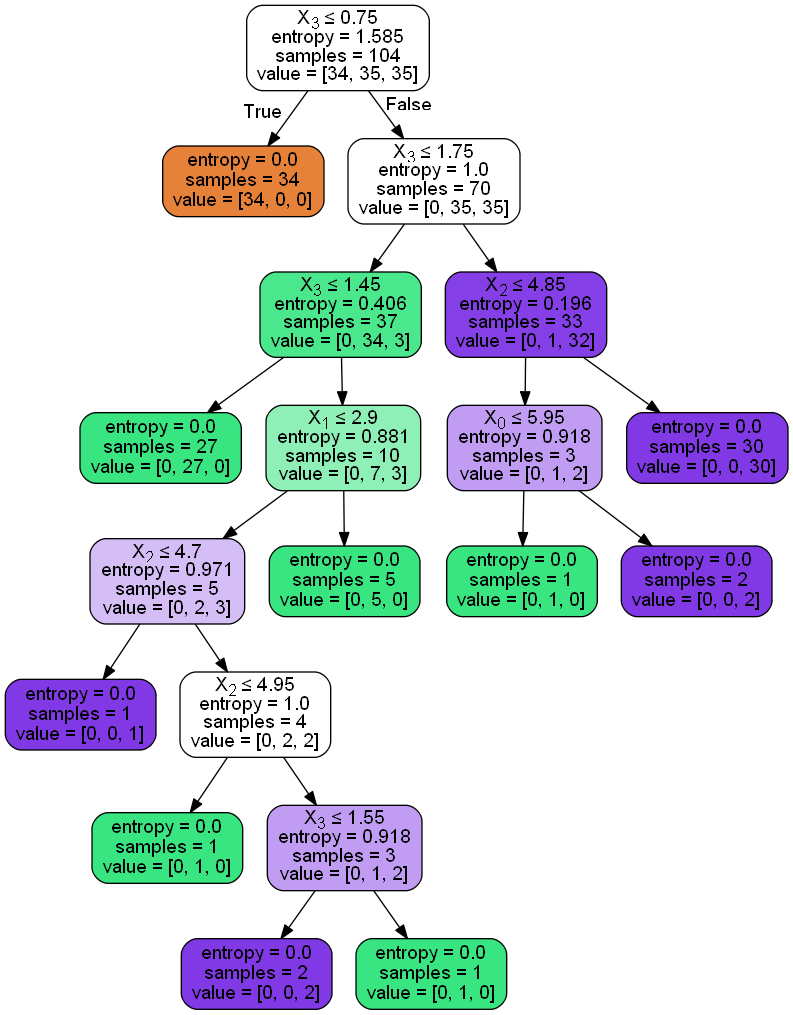

In [314]:
dot_data = StringIO()
export_graphviz(iris_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [315]:
prediction = iris_tree.predict(test_iris.loc[:, test_iris.columns != 'Species'])
print("The prediction accuracy is: ",
      iris_tree.score(test_iris.loc[:, test_iris.columns != 'Species']
                                                     ,test_iris["Species"])*100,"%")

The prediction accuracy is:  91.11111111111111 %
